In [838]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics
using Flight.FlightComponents.Aircraft
using Flight.FlightAircraft.C172FBW

using ControlSystems
using RobustAndOptimalControl

In [839]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics
ac.airframe.pld.u.m_pilot = 75
ac.airframe.pld.u.m_copilot = 75
ac.airframe.pld.u.m_lpass = 0
ac.airframe.pld.u.m_rpass = 0
ac.airframe.pld.u.m_baggage = 0

trim_params = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    ψ_nb = 0.0,
    TAS = 40.0,
    γ_wOb_n = 0.0,
    ψ_lb_dot = 0.00,
    θ_lb_dot = 0.0,
    β_a = 0.0,
    fuel = 1,
    mixture = 0.5,
    flaps = 0.0)

lm = linearize!(ac; trim_params)

u_lon_labels = [:throttle_cmd, :elevator_cmd]
x_lon_labels = [:q, :θ, :v_x, :v_z, :α_filt, :ω_eng, :thr_v, :thr_p, :ele_v, :ele_p]
y_lon_labels = [:q, :θ, :α, :TAS, :f_x, :f_z, :ω_eng]

long_dyn_lss = filter(lm; u = u_lon_labels, x = x_lon_labels, y = y_lon_labels)

#the open-loop system, with throttle and elevator commands as inputs is our
#baseline plant
thr_ele_MIMO = named_ss(ss(long_dyn_lss), x = x_lon_labels, y = y_lon_labels, u = u_lon_labels)

NamedStateSpace{Continuous, Float64}
A = 
 -4.21869307456935    -3.900794341288316e-6     0.33986255113338243   -4.049618214869186      121.8147976017544     0.004363078259826451     0.0                   0.0                0.0                   9.268525469580444
  0.999998328579363    1.4230898490779373e-14   1.571882697039128e-7   1.4072150026413449e-8    0.0                 0.0                      0.0                   0.0                0.0                   0.0
 -1.1271386879842566  -9.738239462634965       -0.2645904405504637     2.486992195889064      -70.62142281045607    0.016378879126736922     0.0                   0.0                0.0                  -5.831834749449598
 38.40353747785689    -0.8717969673217496      -0.2320629144731776    -2.892436502843294       34.743313226339566   0.0003989943970161073    0.0                   0.0                0.0                   3.5904066588780665
  0.0                  0.0                     -0.11145971643636479    1.2450207738

## 1. Pitch Rate Control

In [840]:
e2q_ol = thr_ele_MIMO[:q, :elevator_cmd]
@show zpk(e2q_ol)

#error transfer function with a unit feedback closed loop for a unit step input
ε_e2q_cl = 1/(1+tf(e2q_ol))
#steady-state error
@show ε_e2q_cl(0)

#the steady state error is finite, but very close to 1. this is because the open
#loop TF is type 0, but with a zero almost at the origin, so in practice it has
#nearly derivative action. 

#therefore, although the integrador in a PID compensator will in theory yield a
#type 1 system (and zero steady state error for step inputs), in practice (for
#reasonable time windows) the system will still behave as a type 0. so, in
#addition to this we can expect to require a pure integrator in the feedforward
#path for satisfactory response.

zpk(e2q_ol) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                  (1.0s + 49.667130350637954)(1.0s + 9.582552275632255)(1.0s + 1.6236140469521279)(1.0s + 3.1038525683487615e-5)(1.0s + 0.04911473110426945)
36590.67190647199-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s + 48.315816004398656)(1.0s^2 + 75.39822368615503s + 3947.8417604357433)(1.0s + 9.582017994069489)(1.0s^2 + 8.97767199427668s + 49.644235645519394)(1.0s^2 + 0.04819984770640107s + 0.09426977979507291)

Continuous-time transfer function model
ε_e2q_cl(0) = [0.9999949607402965;;]


1×1 Matrix{Float64}:
 0.9999949607402965

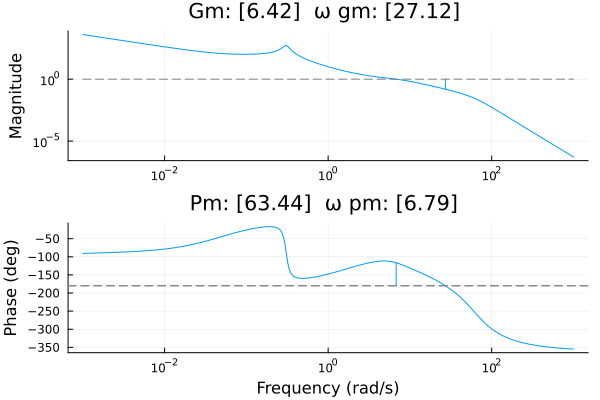

In [841]:
#pitch rate compensator PID
k_p = 5.2
k_i = 25
k_d = 0.45
τ_d = 0.05

#less agressive design
# k_p = 3.8
# k_i = 20
# k_d = 0.29
# τ_d = 0.05

#compensator is an integrator in series with the PID
qcmp_tf = tf(1, [1, 0]) * (k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [τ_d, 1]))

#input to the pitch rate compensator is pitch rate error, output is
#elevator_cmd, which feeds into e2q
qcmp = named_ss(ss(qcmp_tf), :qcmp; u = :q_err, y = :elevator_cmd)
qcmp_e2q_ol = series(qcmp, e2q_ol)

#steady-state error for a unit step input, now zero
ε_qcmp_e2q_cl = 1/(1+tf(qcmp_e2q_ol))
ε_qcmp_e2q_cl(0)

marginplot(qcmp_e2q_ol) 

10-element Vector{ComplexF64}:
   -39.06897063039854 + 49.569174551879684im
   -39.06897063039854 - 49.569174551879684im
  -48.477862440167584 + 0.0im
   -5.874288909838738 + 8.841748196225144im
   -5.874288909838738 - 8.841748196225144im
 -0.04850897588388924 + 0.0im
   -2.226863743847071 + 1.4122661892591166im
   -2.226863743847071 - 1.4122661892591166im
   -9.564814463899861 + 0.0im
   -9.890466059900882 + 0.0im

StepInfo:
Initial value:     0.000
Final value:       0.992
Step size:         0.992
Peak:              1.122
Peak time:         0.889 s
Overshoot:         13.10 %
Undershoot:         0.00 %
Settling time:     1.841 s
Rise time:         0.163 s


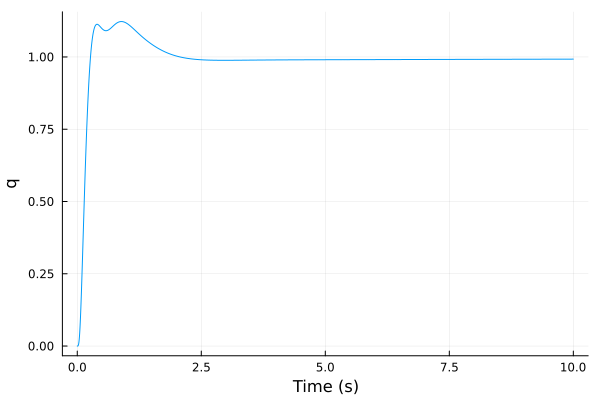

In [842]:
qcmp_e2q_cl = feedback(qcmp_e2q_ol)
qcmp_e2q_cl_step = step(qcmp_e2q_cl, 10)

poles(minreal(qcmp_e2q_cl, 1e-3)) |> display
stepinfo(qcmp_e2q_cl_step) |> display
qcmp_e2q_cl_step |> plot


Now we have a SISO compensator design, we need to use it to close the loop in the MIMO plant.

First, we will do it manually. The baseline MIMO system has two inputs, throttle_cmd and elevator_cmd. Our SISO compensator receives q_err as an input and outputs elevator_cmd. So the MIMO version of our SISO compensator, which will be placed upstream of the MIMO plant, must receive [throttle_cmd, q_err] as input and output [throttle_cmd, elevator_cmd]. Therefore, it must apply an unit gain to its first input throttle_cmd to let it pass through unchanged, and apply the SISO compensator to its second input q_err to obtain elevator_cmd.

The setpoint vector to be applied to the closed-loop MIMO system is r = [throttle_cmd, q_dmd]. The input to the MIMO compensator must be u = [throttle_cmd, q_err] = r - f = [throttle_cmd, q_dmd] - [0, q]. So we need a matrix gain that premultiplies the 7-component output vector of thr_ele_MIMO, and produces a 2-component vector [0, q]. This will be a 2x7 matrix K_q with all entries set to zero except K_q[2, 1] (the nonzero output goes in the second component, and it is q, the first element in thr_ele_MIMO's output vector)

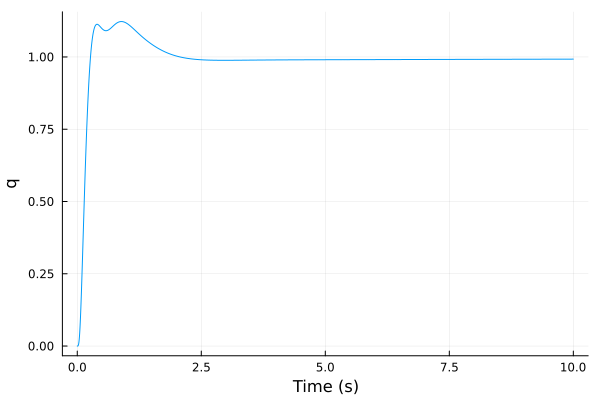

In [843]:
#create a diagonal MIMO system with a unit feedthrough system and the pitch
#rate compensator
qcmp_MIMO = append(ss(1.0), ss(qcmp))
#prepend it to the plant
qcmp_thr_ele_MIMO = series(qcmp_MIMO, ss(thr_ele_MIMO))

#construct feedback system K_q_ss
K_q = zeros(2, 7)
K_q[2,1] = 1 #selects q from thr_ele_MIMO and puts it in the second row
K_q_ss = ss(K_q) #creates a ss with no dynamics and K_q as feedthrough

#create a feedback loop with K_q_ss in the feedback path
thr_q_MIMO_man = feedback(qcmp_thr_ele_MIMO, K_q_ss)

#finally, convert it to a NamedStateSpace with the appropriate labels
thr_q_MIMO_man = named_ss(thr_q_MIMO_man, :thr_q, u = [:throttle_cmd, :q_dmd], y = y_lon_labels)

#check we get the same response as with the SISO closed loop
qdmd2q_man = thr_q_MIMO_man[:q, :q_dmd]
step(qdmd2q_man, 10) |> plot

All this is made much more straightforward by the connect function from RobustAndOptimalControl.jl

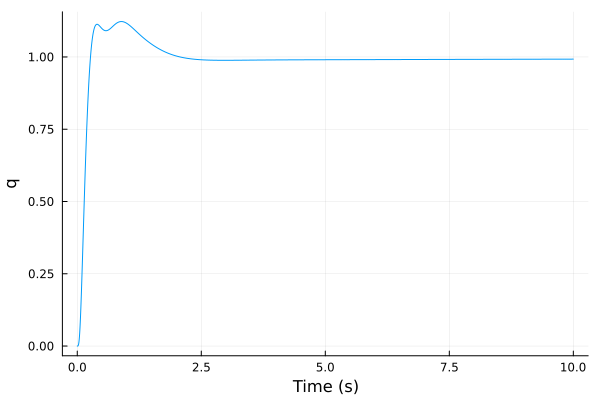

In [844]:
qsum = sumblock("q_err = q_dmd - q")
thr_q_MIMO = connect([qsum, qcmp, thr_ele_MIMO], [:q_err=>:q_err, :q=>:q, :elevator_cmd=>:elevator_cmd], w1 = [:throttle_cmd, :q_dmd], z1 = y_lon_labels)

#test we get the same response as with the SISO closed loop
qdmd2q = thr_q_MIMO[:q, :q_dmd]
step(qdmd2q, 10) |> plot 

#thr_q_MIMO is our new plant baseline: longitudinal dynamics with embedded pitch
#rate control and throttle_cmd and q_dmd as inputs